In [1]:
%%html
<link rel="stylesheet" type="text/css" href="css/rise.css" />

# Maximum Likelihood Estimation (MLE)

In [2]:
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use("bmh")
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12

### Learning goals - *Maximum Likelihood Estimation*
|  |  |  |
|--|--|--|
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will understand what a *likelihood* is.</div> | e.g., L(x) = pdf(x) |
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will be able to compute a joint *likelihood* for all values in a dataset.</div> | `L = np.prod(pdf)` |
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will be able to compute a joint *loglikelihood* for all values in a dataset.</div> | `LL = np.sum(np.log(pdf))` |
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will appreciate why you almost always compute loglikelihoods instead of likelihoods.</div> | numerical underflow |
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will be able to find parameters that maximize the likelihood (i.e., minimize the negative loglikelihood) that a probability distribution explains a dataset.</div> | `opt.minimize` |

# Example

A neuron's resting membrane voltage.

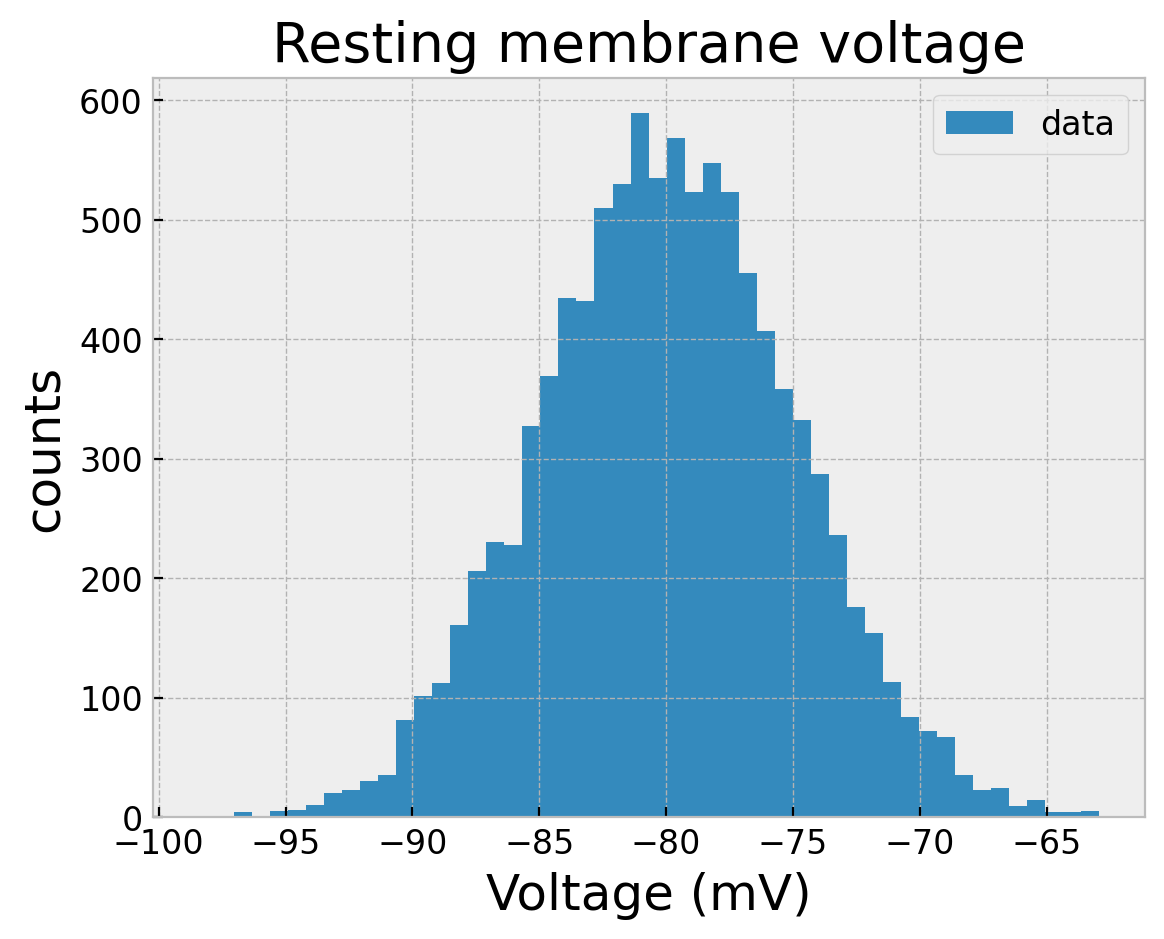

In [3]:
# Simulated data for a neuron's resting membrane voltage (mV)
data = st.norm.rvs(-80, 5, size=10000)

plt.hist(data, 50, label='data')
plt.xlabel('Voltage (mV)')
plt.ylabel('counts')
plt.title('Resting membrane voltage')
plt.legend();

What distribution would you use to describe this data?

What are your best estimates for the distribution parameters?

In [4]:
mu = data.mean()  # mean
sd = data.std()   # standard deviation

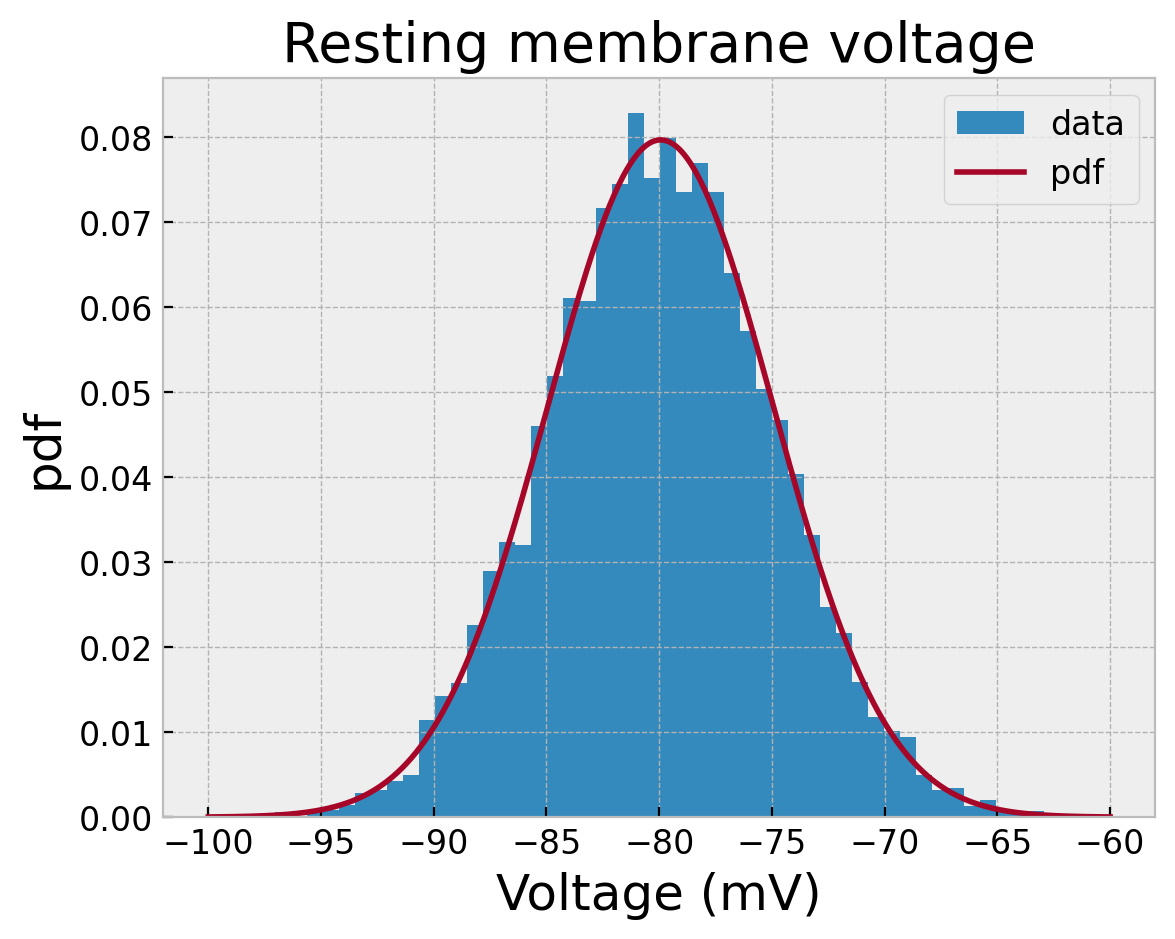

In [5]:
# data
plt.hist(data, 50, label='data', density=True)

# model pdf
x = np.linspace(-100, -60, 401)
plt.plot(x, st.norm.pdf(x, mu, sd), label='pdf')

plt.xlabel('Voltage (mV)')
plt.ylabel('pdf')
plt.title('Resting membrane voltage')
plt.legend();

# Example

Current through an ion channel that is either closed or open.

<img src="images/single-channel-recording.jpg" width="70%">

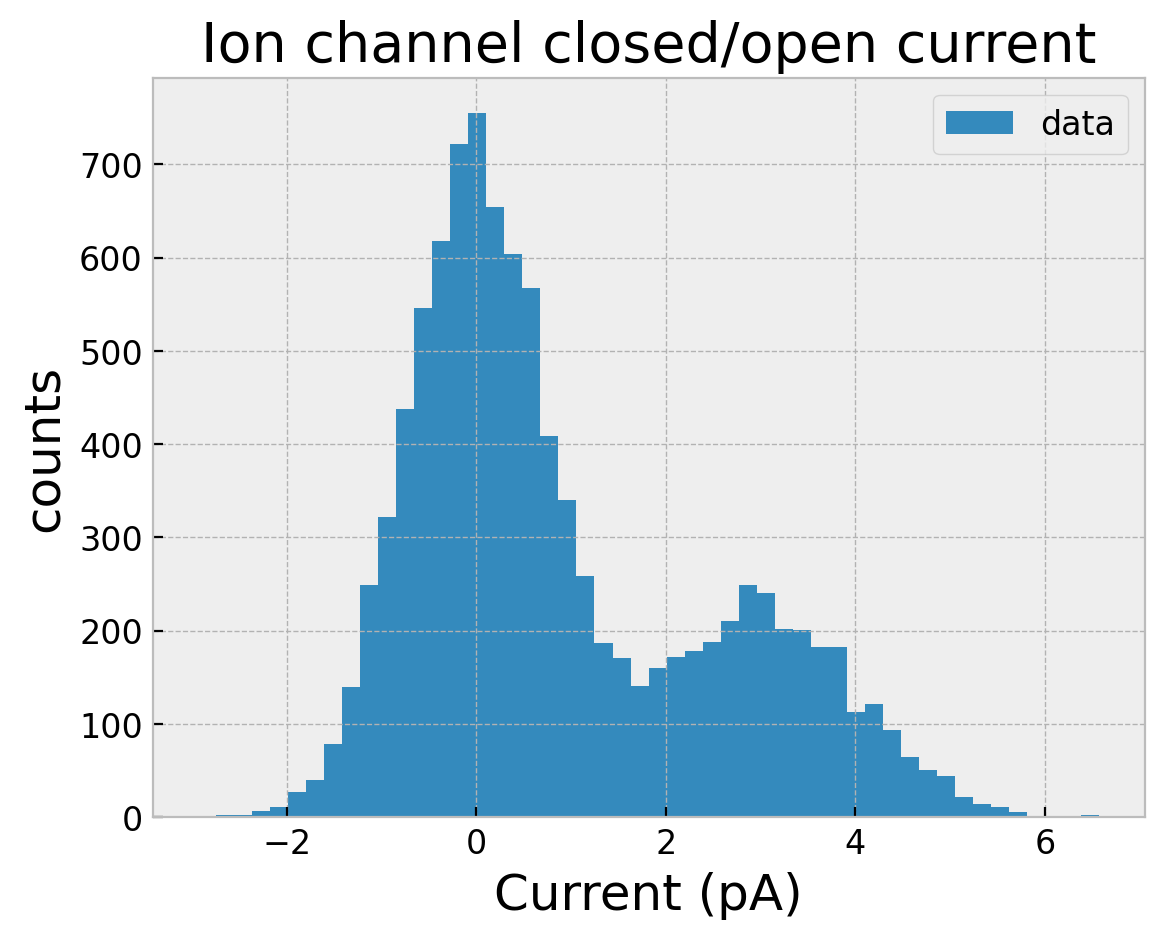

In [6]:
data = np.hstack([
    st.norm.rvs(0, 0.75, size=7000),
    st.norm.rvs(3, 1, size=3000)])

plt.hist(data, 50, label='data')
plt.xlabel('Current (pA)')
plt.ylabel('counts')
plt.title('Ion channel closed/open current')
plt.legend();

What distribution would you use to describe this data?

Not a normal distribution!

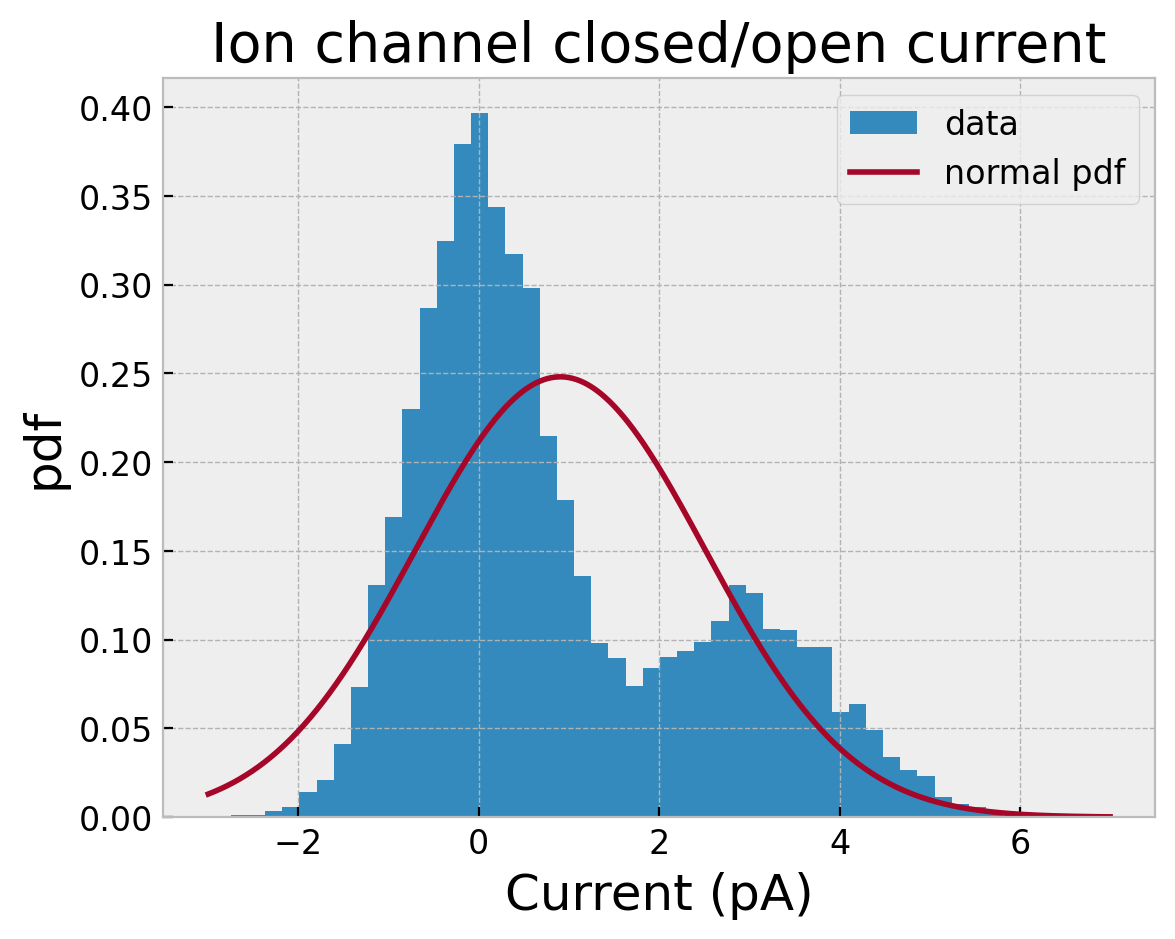

In [7]:
# data
plt.hist(data, 50, label='data', density=True)

# normal pdf
x = np.linspace(-3, 7, 1001)
plt.plot(x, st.norm.pdf(x, data.mean(), data.std()), label='normal pdf')

plt.xlabel('Current (pA)')
plt.ylabel('pdf')
plt.title('Ion channel closed/open current')
plt.legend();

You can construct a **new probability distribution** that is the weighted sum of two different normal distributions.

$pdf = w_1 Normal(\mu_1, \sigma_1) + w_2 Normal(\mu_2, \sigma_2)$

$\int pdf = 1 \hspace{1em} \rightarrow \hspace{1em} w_2 = 1 - w_1$

In [8]:
def my_pdf(x, list_of_params):
    # input parameters
    w1, mu1, sd1, mu2, sd2 = list_of_params
    w2 = 1 - w1

    # output pdf
    N1 = w1 * st.norm.pdf(x, mu1, sd1)
    N2 = w2 * st.norm.pdf(x, mu2, sd2)
    return N1 + N2

What distribution parameters should you use?

Let's start by taking a reasonable guess.

In [9]:
# w1, mu1, sd1, mu2, sd2
params_guess = [0.6, 0, 0.5, 3.5, 1.5]

The *pdf* is defined by the parameters.

In [10]:
x = np.linspace(-3, 7, 1001)

pdf_guess = my_pdf(x, params_guess)

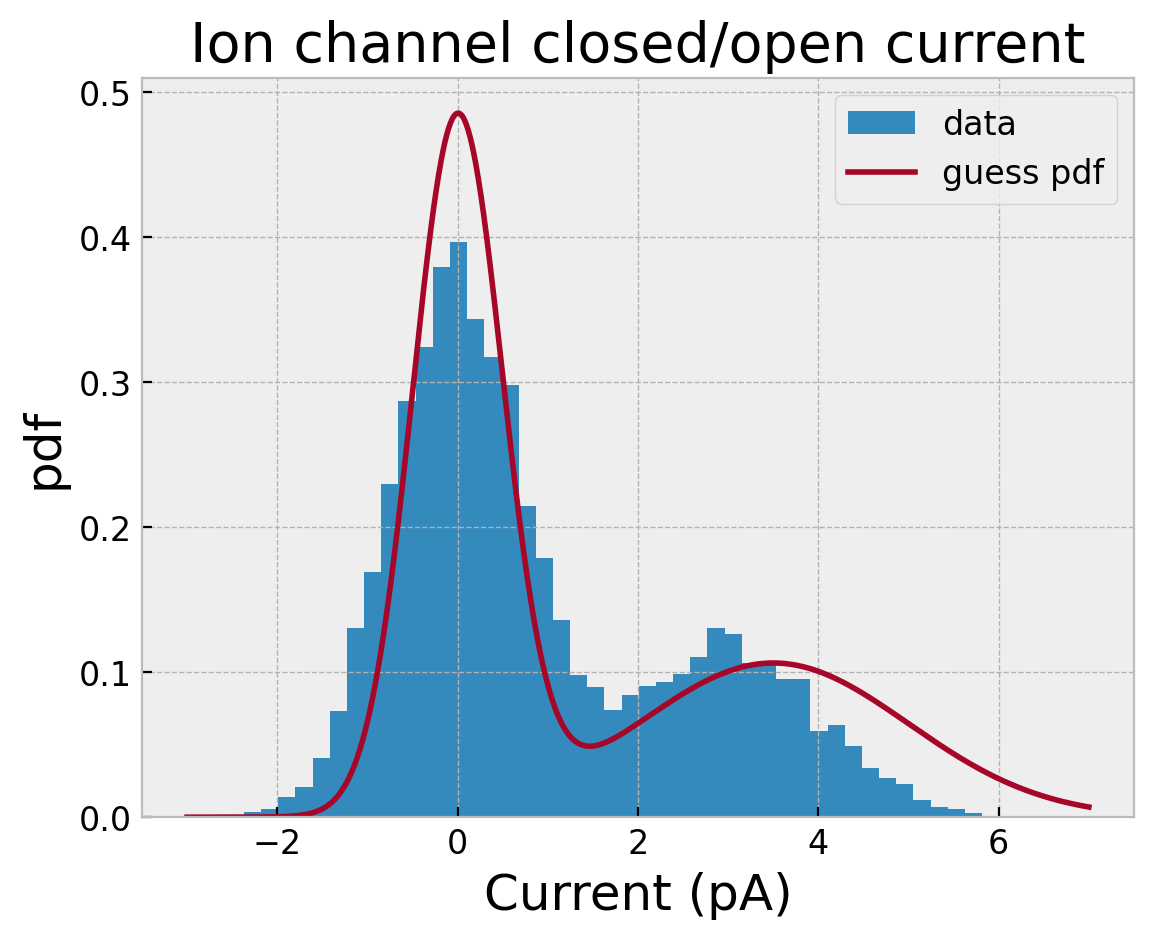

In [11]:
# data
plt.hist(data, 50, label='data', density=True)

# guess pdf
plt.plot(x, pdf_guess, label='guess pdf')

plt.xlabel('Current (pA)')
plt.ylabel('pdf')
plt.title('Ion channel closed/open current')
plt.legend();

Are these the *best possible choice of parameters*?

If not, how will you find them?

Basically, you will try a bunch of different parameters and choose the ones that fit the data best.

But you need some way to quantify how well a particular set of parameters describes the data.

# Likelihood

For a continuous variable, the likelihood ($L$) of observing a value $x$ is simply its probability density $pdf(x)$.

$L(x) = pdf(x)$

The likelihood of observing multiple values $x_1, x_2, ..., x_N$ is simply the product of their individual likelihoods.

$L(x_1, x_2, ..., x_N) = pdf(x_1)pdf(x_2)...pdf(x_N)$

Your goal is to find the parameters that maximize the likelihood of all of your measured data.

Likelihood is the **product of many small numbers** that are all less than one, which for datasets with many data points becomes **VERY small VERY fast**.

$L = pdf(x_1)pdf(x_2)...pdf(x_N)$

There is a minimum value that Python can represent. If any value becomes smaller than this, it will result in an underflow ERROR.

In [12]:
import sys
sys.float_info.min

2.2250738585072014e-308

# Loglikelihood

$L = pdf(x_1)pdf(x_2)...pdf(x_N)$

$LL = log(L) = log(pdf(x_1)) + log(pdf(x_2)) + ... + log(pdf(x_N))$

The same parameters will maximize both $L$ and $LL$.

But $LL$ is unlikely to result in an underflow ERROR. Can you see why?

Thus, $LL$ is almost always used instead of $L$.

# $max(LL) \Rightarrow min(-LL)$

So, your goal is to find the parameters that **maximize the loglikelihood of your measured data**.

These same parameters will also maximize the likelihood.

However, because Python has a minimizer and not a maximizer, you will instead **minimize the negative loglikelihood of your measured data**.

You start by defining a function that returns the negative loglikelihood of your data given a set of model parameters.

In [13]:
def my_negloglikelihood(params):
    
    # array of probability densities for all data points given the input params
    pdf = my_pdf(data, params)
    
    # loglikelihood is the sum of the logs of the pdf's for each data point
    LL = np.sum(np.log(pdf))
    
    # return the negative loglikelihood
    return -LL

Now you want to find the parameters that minimize the value of your negative loglikelihood function.

In [14]:
import scipy.optimize as opt

In [15]:
# starting guess for parameters w1, mu1, sd1, mu2, sd2
start = [0.6, 0, 0.5, 3.5, 1.5]

# (min, max) bounds for each parameter
bnds = [(0, 1), (-2, 2), (0.01, 3), (0, 5), (0.01, 3)]

result = opt.minimize(my_negloglikelihood, start, method='slsqp', bounds=bnds)

/var/folders/cq/0x3wj8sx1_dbbm61zp0zqbmm0000gn/T/ipykernel_6009/3930608402.py:7: RuntimeWarning: divide by zero encountered in log
  LL = np.sum(np.log(pdf))


In [16]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 17219.104216193417
       x: [ 6.963e-01 -7.268e-03  7.300e-01  2.993e+00  1.014e+00]
     nit: 14
     jac: [-3.467e-02  3.174e-02 -1.172e-02 -1.099e-02 -6.104e-03]
    nfev: 98
    njev: 14

In [17]:
result.message

'Optimization terminated successfully'

In [18]:
result.success

True

In [19]:
# optimized parameters: w1, mu1, sd1, mu2, sd2
result.x

array([ 0.69634177, -0.00726758,  0.72995414,  2.99265374,  1.0139754 ])

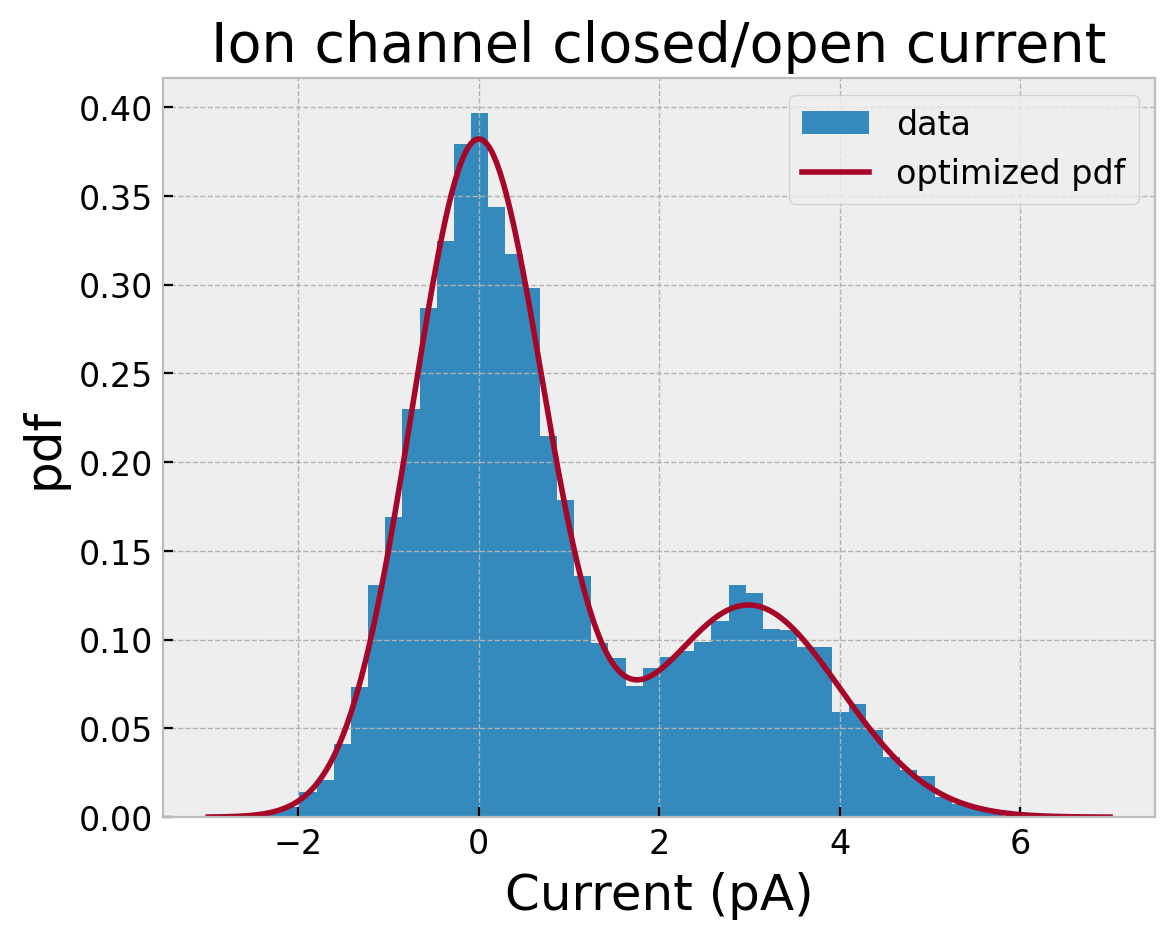

In [20]:
# data
plt.hist(data, 50, label='data', density=True)

# optimized pdf
x = np.linspace(-3, 7, 1001)
plt.plot(x, my_pdf(x, result.x), label='optimized pdf')

plt.xlabel('Current (pA)')
plt.ylabel('pdf')
plt.title('Ion channel closed/open current')
plt.legend();

In [21]:
w1, mu1, sd1, mu2, sd2 = result.x
w2 = 1 - w1

# mu1 = closed, mu2 = open
if mu2 < mu1:
    w1, mu1, sd1, w2, mu2, sd2 = w2, mu2, sd2, w1, mu1, sd1

print(f"Single channel current is {mu2 - mu1 :.2f} pA")
print(f"Closed and open channel noise are {sd1 :.2f} and {sd2 :.2f} pA, respectively")
print(f"Open probability is {w2 :.2f}")

Single channel current is 3.00 pA
Closed and open channel noise are 0.73 and 1.01 pA, respectively
Open probability is 0.30


# Example

A protein is activated by depolarizing the cell membrane, and deactivates upon repolarization by one of two possible pathways, each pathway ocurring at a different average rate. You measure the time to deactivation for a single molecule following each of 10,000 independent repolarizations (see `deact_times` below).

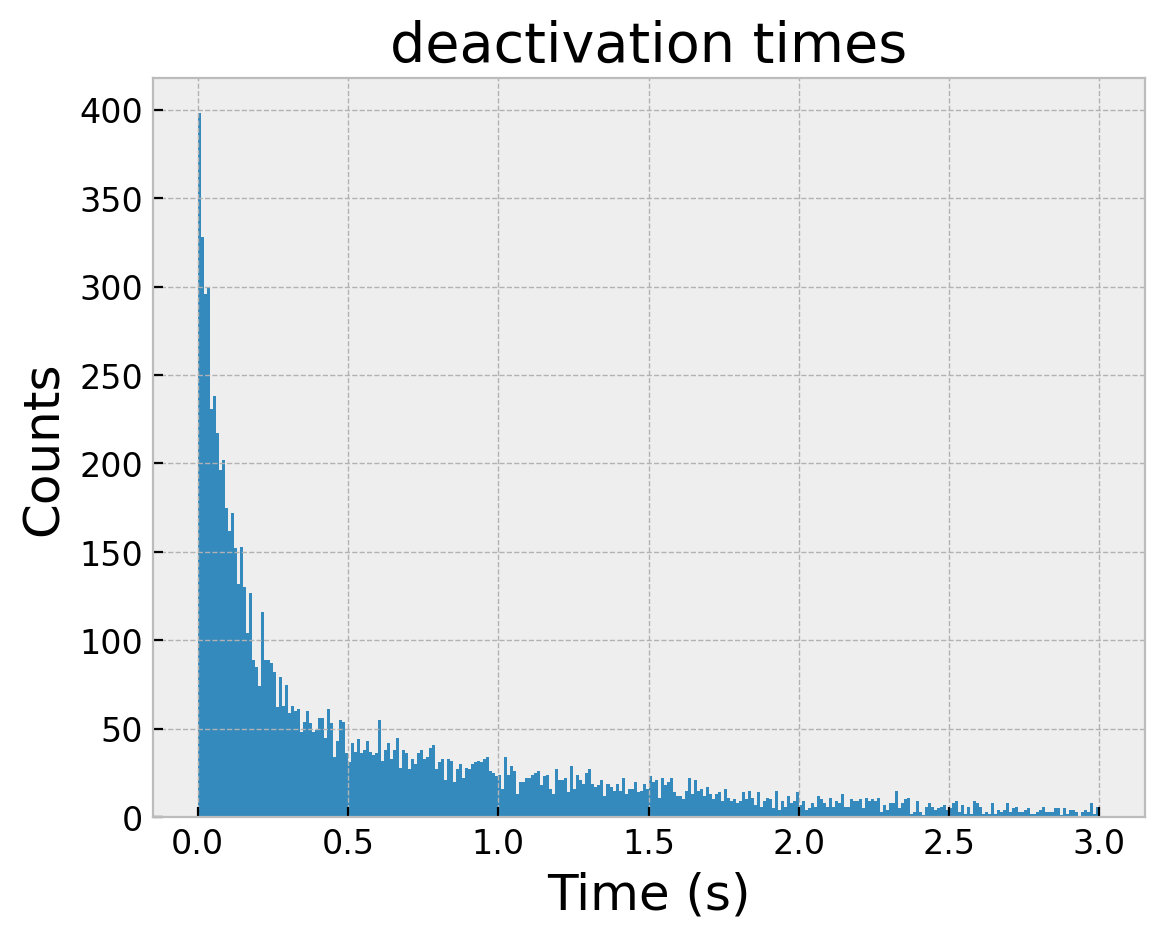

In [22]:
# Simulated deactivation times (sec)
deact_times = st.expon.rvs(0, np.random.choice([0.1, 1.0], size=10000, p=[0.3, 0.7]))

bin_edges = np.linspace(0, 3, 301)
plt.hist(deact_times, bin_edges)
plt.xlabel('Time (s)')
plt.ylabel('Counts')
plt.title('deactivation times');

# Exercise

Use an exponential probability distribution to describe the above `deact_times` and plot the model overlaid on the data to see how well it does.

In [23]:
# # data
# bin_edges = np.linspace(0, 3, 301)
# plt.hist(deact_times, bins=bin_edges, density=True, label='data')

# # exponential pdf
# x = bin_edges
# pdf = ...
# plt.plot(x, pdf, label='exponential pdf')

# plt.xlabel('Time (s)')
# plt.ylabel('pdf')
# plt.title('deactivation times')
# plt.legend();

# Exercise Key

Use an exponential probability distribution to describe the above `deact_times` and plot the model overlaid on the data to see how well it does.

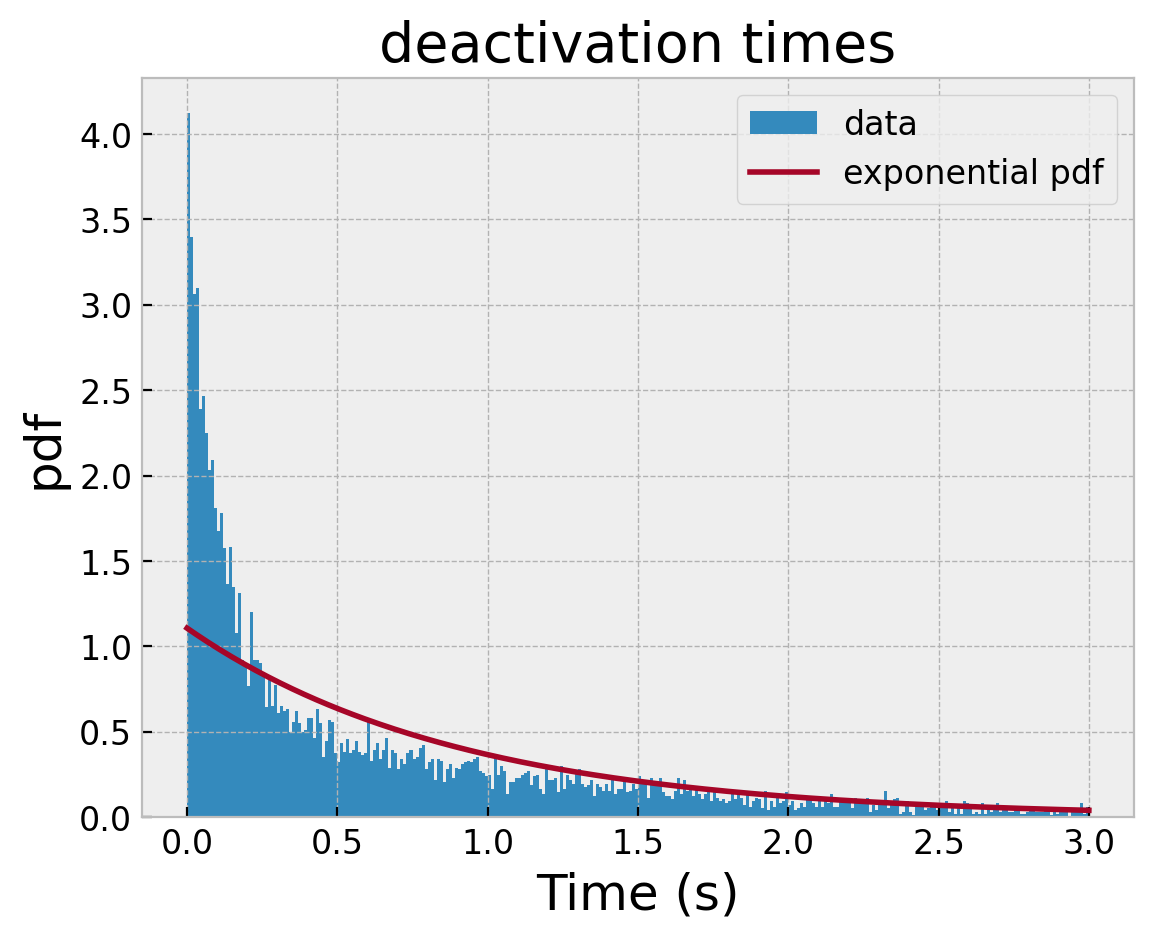

In [24]:
# data
bin_edges = np.linspace(0, 3, 301)
plt.hist(deact_times, bins=bin_edges, density=True, label='data')

# exponential pdf
x = bin_edges
pdf = st.expon.pdf(x, 0, data.mean())
plt.plot(x, pdf, label='exponential pdf')

plt.xlabel('Time (s)')
plt.ylabel('pdf')
plt.title('deactivation times')
plt.legend();

# Exercise

Use the weighted sum of two different exponential distributions to describe the above `deact_times` and plot the model overlaid on the data to see how well it does.

You can construct a **new probability distribution** that is the weighted sum of two different exponential distributions.

$pdf = w_1 Exponential(rate_1) + w_2 Exponential(rate_2)$

$\int pdf = 1 \hspace{1em} \rightarrow \hspace{1em} w_2 = 1 - w_1$

1. Define a function for the weighted sum of two different exponential distributions.

In [25]:
# def biexp_pdf(x, params):
#     ...

2. Define a function that given parameters to your custom distribution returns the negative loglikelihood of the measured deactivation times.

In [26]:
# def negLL(params):
#     ...

3. Make a reasonable guess for the parameters.

In [27]:
# start = [...]

4. Define lower and upper bounds for the parameters.

In [28]:
# bnds = [(...), ...]

5. Starting from your guess above, find the parameters within your defined bounds above that minimize the negative loglikelihood.

In [29]:
# result = opt.minimize(...)
# result

6. Plot the optimized model overlaid on the data.

In [30]:
# # data
# bin_edges = np.linspace(0, 3, 301)
# plt.hist(deact_times, bins=bin_edges, density=True, label='data')

# # bi-exponential pdf
# x = bin_edges
# pdf = ...
# plt.plot(x, pdf, label='bi-exponential pdf')

# plt.xlabel('Time (s)')
# plt.ylabel('pdf')
# plt.title('deactivation times')
# plt.legend();

7. What are the average deactivation rates along each pathway according to your bi-exponential model?

In [31]:
# rate1 = ...
# rate2 = ...

# print(f"Deactivation along pathway 1 occurs at {rate1:.1f} per second.")
# print(f"Deactivation along pathway 2 occurs at {rate2:.1f} per second.")

8. How often does the model predict that each pathway is taken?

In [32]:
# w1 = ...
# w2 = ...

# print(f"Pathways 1 and 2 are traversed {w1*100:.0f}% and {w2*100:.0f}% of the time, respectively.")

### Learning goals - *Maximum Likelihood Estimation*
|  |  |  |
|--|--|--|
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will understand what a *likelihood* is.</div> | e.g., L(x) = pdf(x) |
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will be able to compute a joint *likelihood* for all values in a dataset.</div> | `L = np.prod(pdf)` |
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will be able to compute a joint *loglikelihood* for all values in a dataset.</div> | `LL = np.sum(np.log(pdf))` |
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will appreciate why you almost always compute loglikelihoods instead of likelihoods.</div> | numerical underflow |
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will be able to find parameters that maximize the likelihood (i.e., minimize the negative loglikelihood) that a probability distribution explains a dataset.</div> | `opt.minimize` |

# General optimization

The minimization approach that we have applied to find the parameters that maximize the likelihood of a probability distribution is generally applicable to many other optimization problems.

### Learning goals - Optimization
|  |  |  |
|--|--|--|
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will be able to find optimal parameters for any model by minimizing an error function that compares the model to data.</div> | `opt.minimize` |
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will understand the concept of gradient descent.</div> | |
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will understand the difference between local and global optimization.</div> | |

# Example: Curve fitting 

Consider the decay time course of an excitatory postsynaptic current (EPSC).

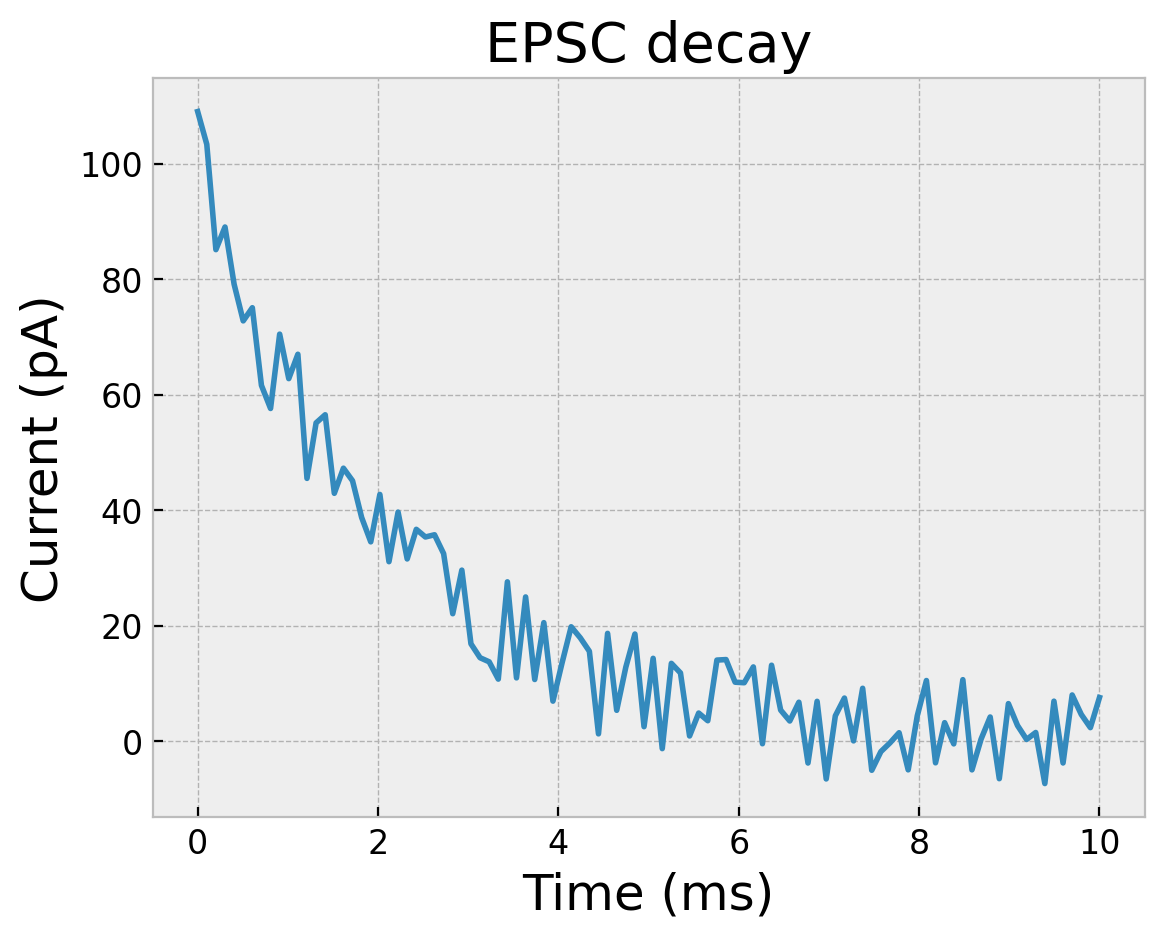

In [33]:
time_ms = np.linspace(0, 10, 100)
epsc_decay_pA = 100 * np.exp(-time_ms / 2) + 20 * (np.random.rand(len(time_ms)) - 0.5)

plt.plot(time_ms, epsc_decay_pA)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('EPSC decay');

Define a function to model the EPSC decay.

In [34]:
def my_decay(time, params):
    amp, tau = params
    return amp * np.exp(-time / tau)

Define a cost function that returns the sum of squared errors (SSE) between the model function above and the EPSC data.

In [35]:
def sse(params):
    data = epsc_decay_pA
    model = my_decay(time_ms, params)
    return np.sum((data - model)**2)

Find the model parameters that minimize the SSE between the model decay and the EPSC data.

In [36]:
start = [80, 4]
result = opt.minimize(sse, start, method='slsqp', bounds=[(50, 150), (0.1, 10)])
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3478.089890286336
       x: [ 1.002e+02  2.076e+00]
     nit: 11
     jac: [-2.441e-04 -2.380e-03]
    nfev: 38
    njev: 11

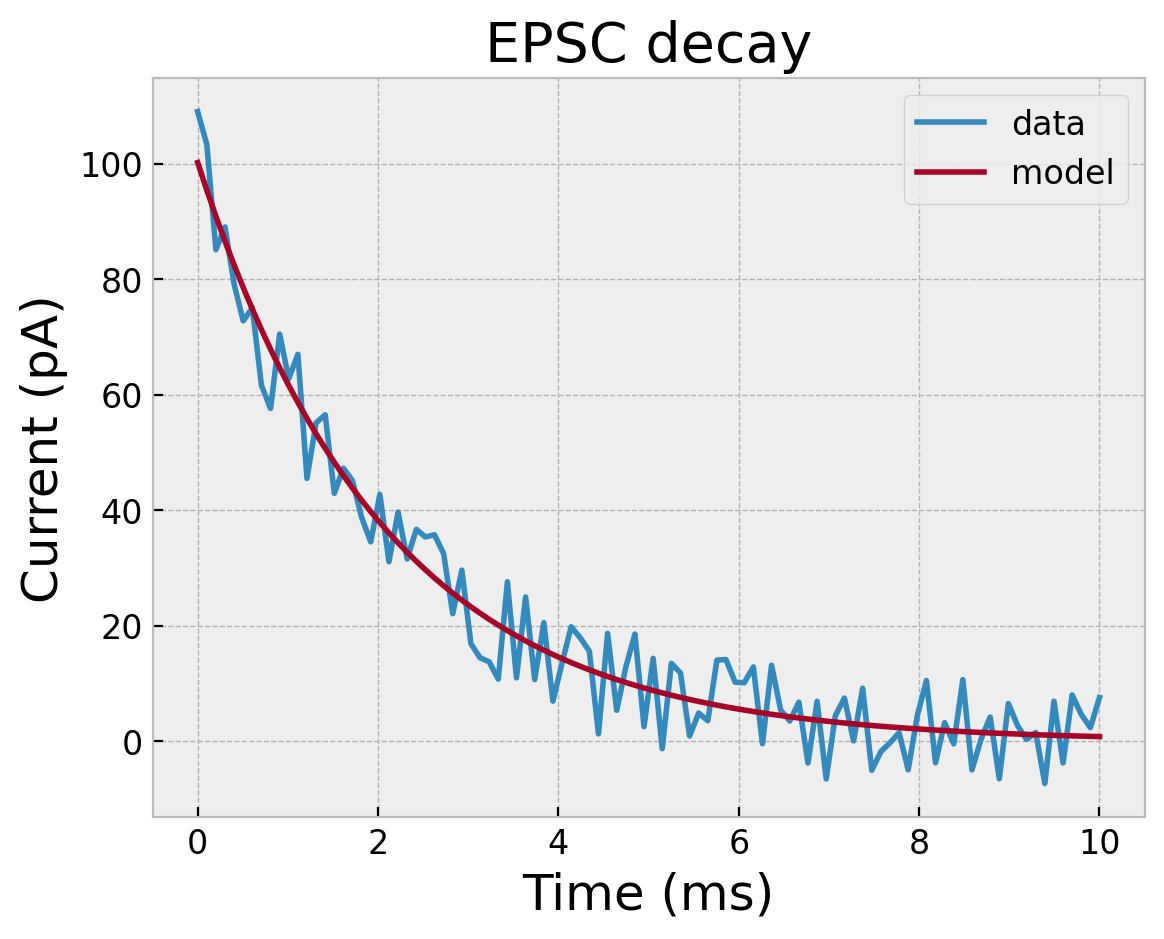

In [37]:
plt.plot(time_ms, epsc_decay_pA, label='data')
plt.plot(time_ms, my_decay(time_ms, result.x), label='model')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('EPSC decay')
plt.legend();

Visualize the 2D SSE surface that we were searching for a minimum on in the EPSC decay example above.

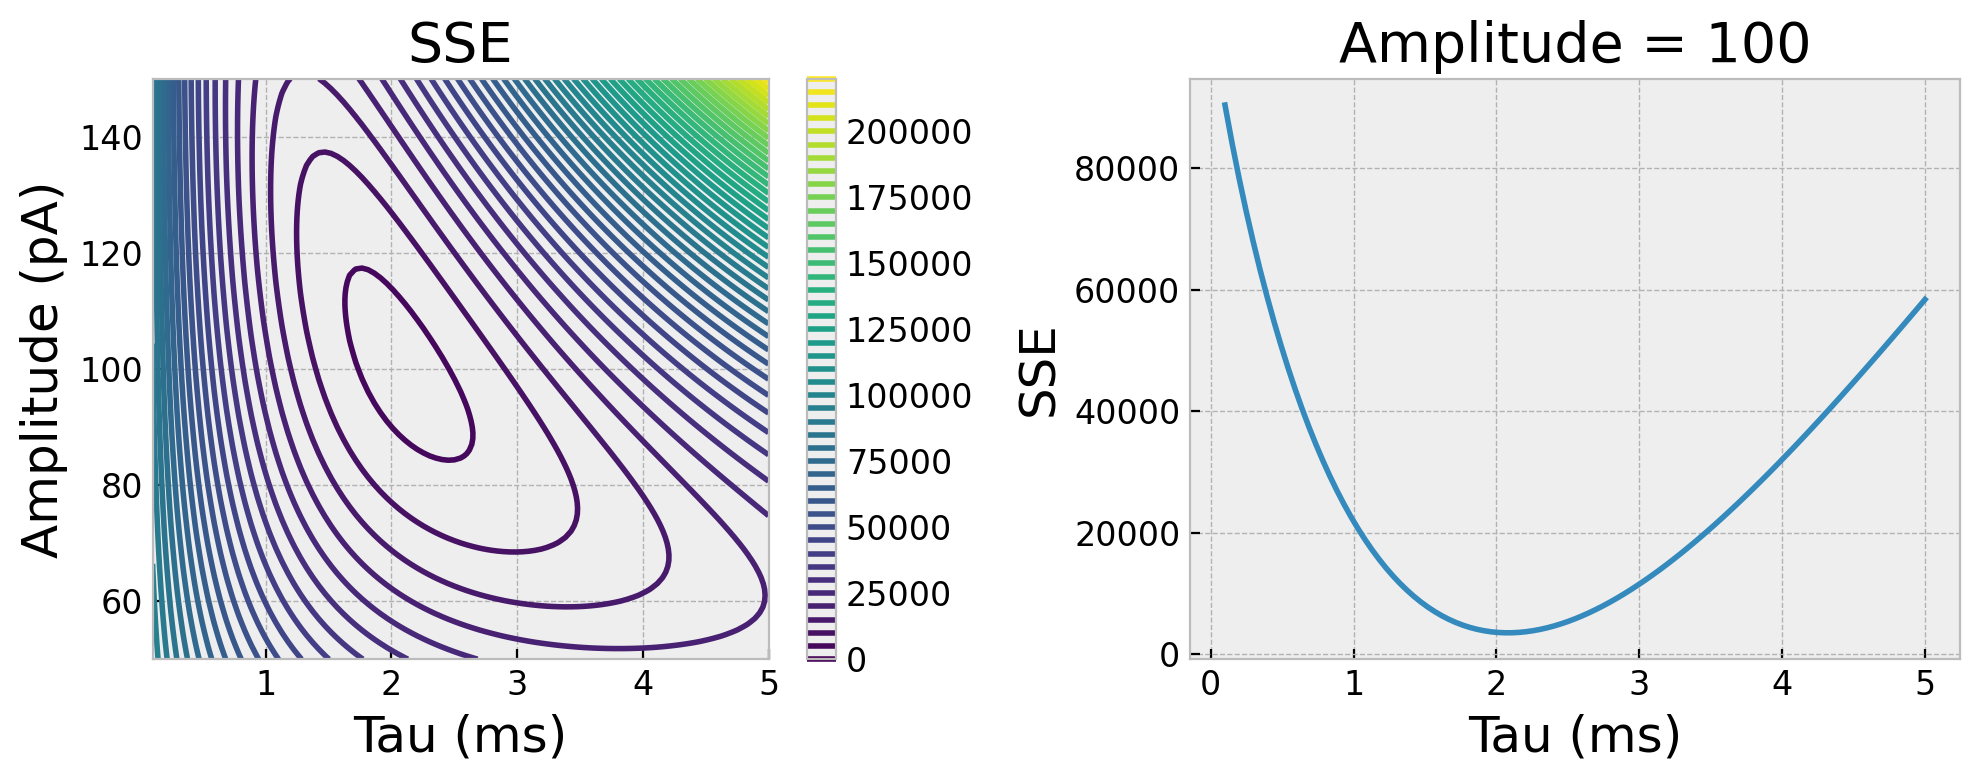

In [38]:
# SSE surface
amps = np.linspace(50, 150, 101)
taus = np.linspace(0.1, 5, 101)

cost = np.zeros((len(amps), len(taus)))

for i, amp in enumerate(amps):
    for j, tau in enumerate(taus):
        cost[i,j] = sse([amp, tau])

plt.figure(figsize=(10,4))
# rows = amps, columns = taus ==> x = taus, y = amps
plt.subplot(1, 2, 1)
plt.contour(taus, amps, cost, 50)
# plt.hlines(amps[50], taus[0], taus[-1])
plt.xlabel('Tau (ms)')
plt.ylabel('Amplitude (pA)')
plt.title('SSE')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.plot(taus, cost[50,:])
plt.xlabel('Tau (ms)')
plt.ylabel('SSE')
plt.title(f'Amplitude = {amps[50]:.0f}')
plt.tight_layout();

It is difficult to visualize, but mathematically simple to find a minimum in three or more dimensions (i.e, three or more parameters).

# Gradient Descent

<img src="images/gradient-descent.gif" width="50%">

# Global vs Local Minima

<img src="images/local-global-minima.png" width="75%">

Consider a simple cost function with two local minima and one global minima.

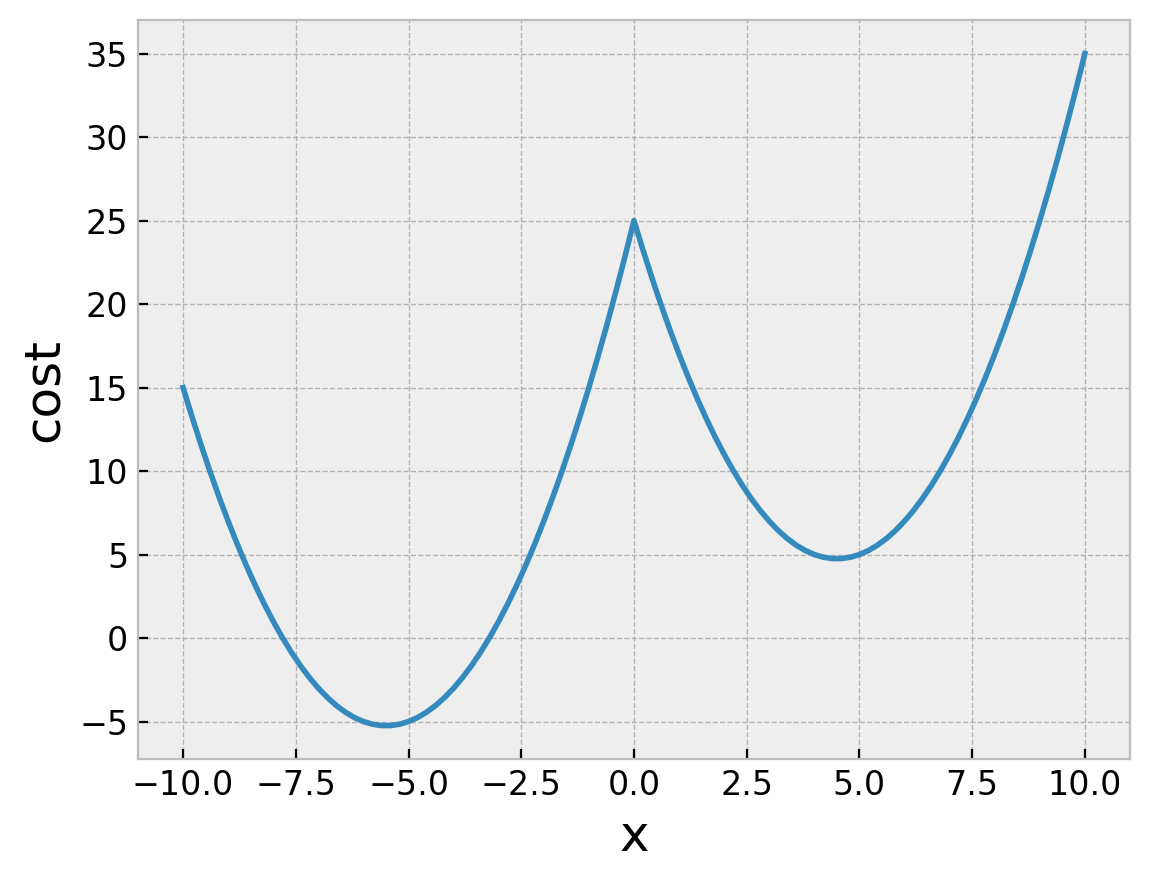

In [39]:
def cost(x):
    return (abs(x) - 5)**2 + x

x = np.linspace(-10, 10, 101)
plt.plot(x, cost(x))
plt.xlabel('x')
plt.ylabel('cost');

Find the minima starting at either $x=-10$ or $x=+10$.

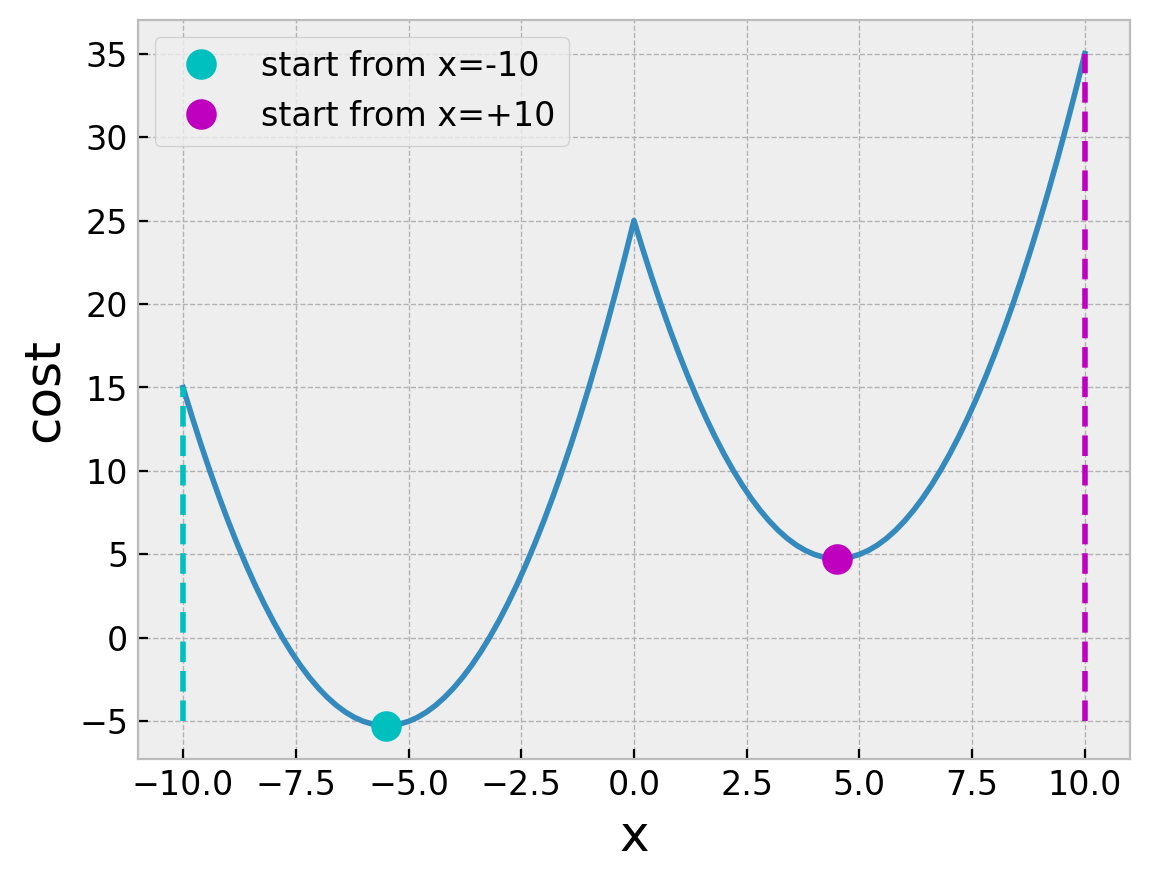

In [40]:
result_from_left = opt.minimize(cost, [-10])
xmin_from_left = result_from_left.x[0]

result_from_right = opt.minimize(cost, [+10])
xmin_from_right = result_from_right.x[0]

plt.plot(x, cost(x))
plt.plot(xmin_from_left, cost(xmin_from_left), 'co', ms=10, label='start from x=-10')
plt.plot(xmin_from_right, cost(xmin_from_right), 'mo', ms=10, label='start from x=+10')
plt.vlines(-10, -5, 15, 'c', ls='--')
plt.vlines(+10, -5, 35, 'm', ls='--')
plt.xlabel('x')
plt.ylabel('cost')
plt.legend();

# Global Minima

There are a number of methods that attempt to find the global minima rather than the nearest local minima.

[e.g. basin hopping, brute force, annealing, SHG.](https://docs.scipy.org/doc/scipy/reference/optimize.html)

<img src="images/local-global-minima.png" width="50%">

Find global minimum using dual annealing.

In [41]:
# find value global minimum within the range -10 <= x <= 10.
result = opt.dual_annealing(cost, bounds=[(-10, 10)])

result

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -5.25
       x: [-5.500e+00]
     nit: 1000
    nfev: 2007
    njev: 3
    nhev: 0

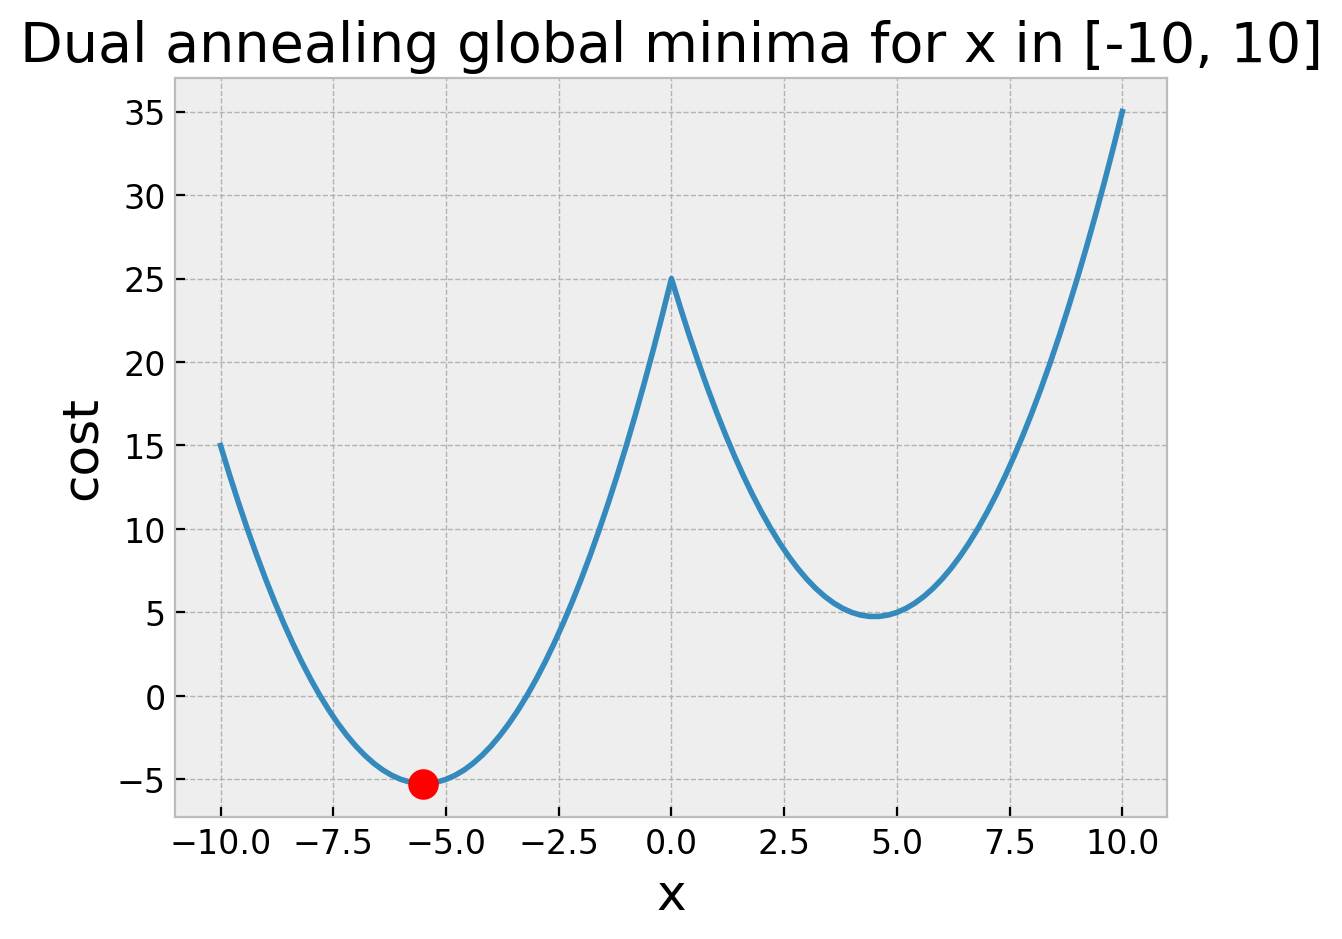

In [42]:
xmin = result.x[0]

plt.plot(x, cost(x))
plt.plot(xmin, cost(xmin), 'ro', ms=10)
plt.xlabel('x')
plt.ylabel('cost')
plt.title('Dual annealing global minima for x in [-10, 10]');

### Learning goals - Optimization
|  |  |  |
|--|--|--|
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will be able to find optimal parameters for any model by minimizing an error function that compares the model to data.</div> | `opt.minimize` |
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will understand the concept of gradient descent.</div> | |
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will understand the difference between local and global optimization.</div> | |